In [2]:
from fastai.tabular.all import *
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Read the csv file into a dataframe

In [3]:
cwd = os.getcwd()
parent = os.path.dirname(cwd)
csv_path = os.path.join(parent, "data/", "master_results.csv")

In [4]:
df = pd.read_csv(csv_path, low_memory=False)
df.head(3)

,p_in,Re,Geometry
0,11.922400,532.38,channelStripRe
1,12.093420,760.11,channelStripRe
2,6.648019,1898.78,leftStripBendRe


In [5]:
df.Geometry = df.Geometry.transform(lambda x: x[:-2])

Let's look at the pressure column

In [6]:
df['p_in'].describe()

count    6.400000e+02
mean     9.761427e+20
std      2.469467e+22
min      2.455772e-01
25%      9.476800e-01
50%      2.528182e+00
75%      7.338899e+00
max      6.247313e+23
Name: p_in, dtype: float64

From the values above we can see that some of the flow cases have not been solved properly by openFOAM. Let's drop all of the unnatural values.

In [7]:
df['p_in'] = np.where(df['p_in'] > 100, False, df['p_in'])
labels = df['p_in'] != False
df = df.loc[labels, :]
df.shape

(625, 3)

In [8]:
df['p_in'].describe()

count    625.000000
mean       5.198978
std        8.167323
min        0.245577
25%        0.926666
50%        2.519571
75%        6.740670
max       88.850320
Name: p_in, dtype: float64

In [9]:
df['p_in'] = np.log1p(df['p_in'])

In [10]:
procs = [Categorify,  Normalize]
cat = "Geometry"
cont = "Re"
dep_var = "p_in"

We will randomly split the dataset into a training and validation sets.

In [11]:
splits = RandomSplitter()(df)
tabular_set = TabularPandas(
    df=df,
    procs=procs,
    cat_names=cat,
    cont_names=cont,
    y_names=dep_var,
    y_block=RegressionBlock(),
    splits=splits
)

In [12]:
# Create DataLoaders
dls = tabular_set.dataloaders(bs=16)  # Batch size 64

In [13]:
learn = tabular_learner(
    dls, 
    layers=[50, 25],  
    metrics=mae)

Let's check the embeddings

In [14]:
list(learn.model.embeds.named_children())

[('0', Embedding(9, 5))]

Find the optimal learning rate

SuggestedLRs(valley=0.02754228748381138)

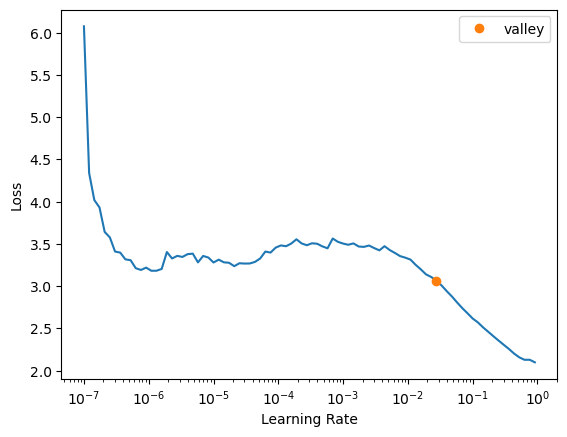

In [88]:
learn.lr_find()

In [15]:
# Train for a few epochs
learn.fit(10, lr=0.01)  # Very small LR to test

epoch,train_loss,valid_loss,mae,time
0,1.196140,0.583391,0.551858,00:00
1,0.526362,0.117868,0.229321,00:00
2,0.326839,0.056822,0.143427,00:00
3,0.246186,0.076154,0.203819,00:00
4,0.188265,0.061298,0.143730,00:00
5,0.169466,0.094415,0.226267,00:00
6,0.172976,0.066884,0.164511,00:00
7,0.151030,0.056470,0.143731,00:00
8,0.154339,0.096324,0.202124,00:00
9,0.142652,0.068422,0.140247,00:00


In [16]:
preds, targets = learn.get_preds(dl=dls.valid)


In [17]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

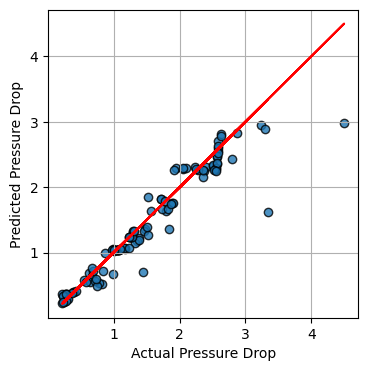

In [18]:
plt.figure(figsize=(4,4))
plt.scatter(targets, preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.grid()
plt.show()

In [19]:
# Get embedding layers
def get_embeddings(learn, cat_var_name):
    """Extract embeddings for a specific categorical variable"""
    # Find the embedding layer for this variable
    emb_layer = None
    for name, layer in learn.model.embeds.named_children():
        if name == cat_var_name:
            emb_layer = layer
            break
    
    if emb_layer is None:
        print(f"Embedding layer for {cat_var_name} not found")
        return None
    
    # Extract weights (embedding matrix)
    embeddings = emb_layer.weight.data.cpu().numpy()
    return embeddings

# Example usage
embeddings = get_embeddings(learn, '0')

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [21]:
dls.classes['Geometry']

['#na#', 'backwardStep', 'bend', 'channel', 'channelStrip', 'forwardStep', 'leftStripBend', 'narrowEndBend', 'rightStripBend']

In [22]:
reducer = PCA(n_components=2)

In [23]:
embeddings_2d = reducer.fit_transform(embeddings)
embeddings_2d

array([[ 0.05540207,  0.00460554],
       [-0.34887734,  0.08862391],
       [-0.12301904, -0.00108454],
       [-0.24281666,  0.06951194],
       [ 0.31176332,  0.11452598],
       [-0.08917784, -0.19056952],
       [ 0.28216207, -0.04009593],
       [ 0.02096098, -0.10745738],
       [ 0.13360243,  0.06194   ]], dtype=float32)

Text(0.5, 1.0, 'Embedding Space')

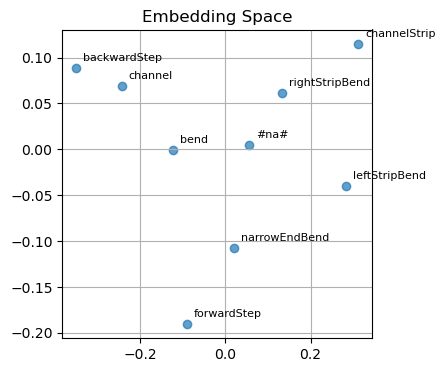

In [24]:
plt.figure(figsize=(4, 4))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
# Add labels for some points
for i, (x, y) in enumerate(embeddings_2d):
    plt.annotate(dls.classes['Geometry'][i], (x, y), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)
plt.grid()
plt.title("Embedding Space")


In [ ]:
save_pickle('models/baselineModel.pkl', learn)